# Intervention Analysis: Phase B Causal Intervention Results

This notebook provides a comprehensive analysis of the reasoning vector intervention experiments.

**Key Research Questions:**
1. **Sufficiency**: Does adding the reasoning direction (α > 0) improve performance?
2. **Necessity**: Does lesioning the reasoning direction harm performance?
3. **Specificity**: Is the learned direction better than random directions?
4. **Rescue**: Does lesion→add restore original behavior?

**Contents:**
1. Setup and Data Loading
2. Summary Statistics
3. Alpha Sweep Analysis
4. Flip Analysis (Wrong→Right vs Right→Wrong)
5. Specificity Analysis (Add vs Random)
6. Layer Sensitivity Analysis
7. **Lesion Analysis (Necessity)**
8. **Rescue Analysis (Recovery)**
9. Statistical Tests
10. Conclusions

## 1. Setup and Data Loading

In [1]:
import sys
sys.path.insert(0, '../..')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import evaluation modules
from evaluation import load_data, metrics, plots, statistical_tests

# Set up plotting
plots.setup_style()

# Output directory for figures
OUTPUT_DIR = Path('../outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Setup complete!')

Setup complete!


In [2]:
# Load data from vm_results
RESULTS_DIR = Path('../../vm_results')

# Load all runs
df = load_data.load_all_runs(RESULTS_DIR)

# Print summary
load_data.print_data_summary(df)

DATA SUMMARY
Total rows: 1200
Unique examples: 25
Models: ['Qwen2.5-7B-Instruct']
Datasets: ['mmlu_pro']
Modes: ['add', 'lesion', 'random', 'rescue']
Layers: [25, 26, 27]
Alpha values: [0.0, 0.5, 1.0, 2.0, nan]
Localities: ['answer', 'cot']


In [3]:
# Filter to paired experiments (add/random) for main analysis
paired_df = load_data.get_paired_experiments(df)
print(f"\nPaired experiments: {len(paired_df)} rows")

# Also get lesion and rescue experiments
lesion_df = load_data.get_lesion_experiments(df)
rescue_df = load_data.get_rescue_experiments(df)
print(f"Lesion experiments: {len(lesion_df)} rows")
print(f"Rescue experiments: {len(rescue_df)} rows")

# Load rescue summary (pre-computed aggregated metrics)
rescue_summary = load_data.load_all_rescue_summaries(RESULTS_DIR)
print(f"Rescue summary rows: {len(rescue_summary)}")


Paired experiments: 900 rows
Lesion experiments: 150 rows
Rescue experiments: 150 rows
Rescue summary rows: 6


## 2. Summary Statistics

In [4]:
# Compute overall summary
summary = metrics.compute_summary(paired_df)

print("Overall Summary Statistics:")
print("=" * 50)
for key, value in summary.items():
    if value is not None:
        if isinstance(value, float):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

Overall Summary Statistics:
n_total: 900
n_unique_examples: 25
baseline_accuracy_answer: 0.5078
baseline_accuracy_reasoning: 0.8156
add_n: 450
add_delta_answer: 0.0156
add_delta_reasoning: -0.0378
add_wrong_to_right: 15
add_right_to_wrong: 8
add_net_gain: 7
add_total_flips: 23
random_n: 450
random_delta_answer: 0.0067
random_delta_reasoning: 0.0089
random_wrong_to_right: 13
random_right_to_wrong: 10
random_net_gain: 3
random_total_flips: 23


In [5]:
# Aggregated results by mode, layer, alpha
agg_df = metrics.aggregate_by_config(paired_df, ['mode', 'layer', 'alpha'], 'answer')
print("\nAggregated Results by Configuration:")
display(agg_df)


Aggregated Results by Configuration:


,mode,layer,alpha,n,acc_base,acc_intv,delta,wrong_to_right,right_to_wrong,net_gain,total_flips
0,add,25,0.5,50,0.50,0.52,0.02,2,1,1,3
1,add,25,1.0,50,0.48,0.52,0.04,3,1,2,4
2,add,25,2.0,50,0.50,0.56,0.06,3,0,3,3
3,add,26,0.5,50,0.52,0.52,0.00,1,1,0,2
4,add,26,1.0,50,0.48,0.54,0.06,3,0,3,3
5,add,26,2.0,50,0.52,0.50,-0.02,1,2,-1,3
6,add,27,0.5,50,0.56,0.52,-0.04,0,2,-2,2
7,add,27,1.0,50,0.48,0.52,0.04,2,0,2,2
8,add,27,2.0,50,0.52,0.50,-0.02,0,1,-1,1
9,random,25,0.5,50,0.48,0.52,0.04,3,1,2,4


In [6]:
# Summary table formatted for publication
summary_table = metrics.generate_summary_table(paired_df)
print("\nPublication-Ready Summary Table:")
display(summary_table)


Publication-Ready Summary Table:


,mode,alpha,n,acc_base,acc_intv,delta,wrong_to_right,right_to_wrong,net_gain,total_flips
0,add,0.5,150,52.7%,52.0%,-0.7%,3,4,-1,7
1,add,1.0,150,48.0%,52.7%,+4.7%,8,1,7,9
2,add,2.0,150,51.3%,52.0%,+0.7%,4,3,1,7
3,random,0.5,150,50.0%,51.3%,+1.3%,6,4,2,10
4,random,1.0,150,51.3%,50.7%,-0.7%,2,3,-1,5
5,random,2.0,150,51.3%,52.7%,+1.3%,5,3,2,8


## 3. Alpha Sweep Analysis

How does intervention strength (α) affect performance?

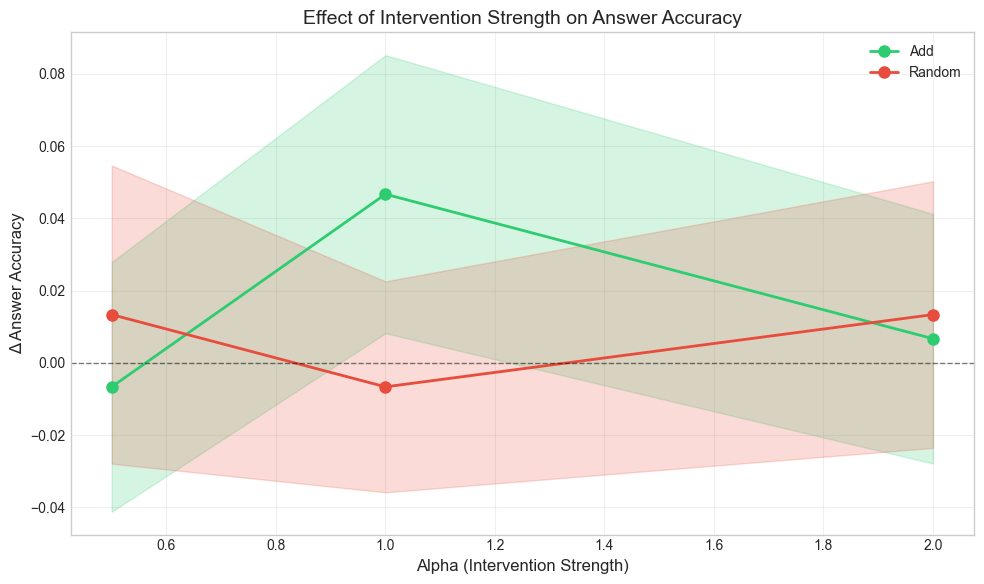

In [7]:
# Overall alpha sweep
fig, ax = plots.plot_alpha_sweep(paired_df, metric='answer',
                                  title='Effect of Intervention Strength on Answer Accuracy',
                                  save_path=OUTPUT_DIR / 'alpha_sweep_answer.pdf')
plt.show()

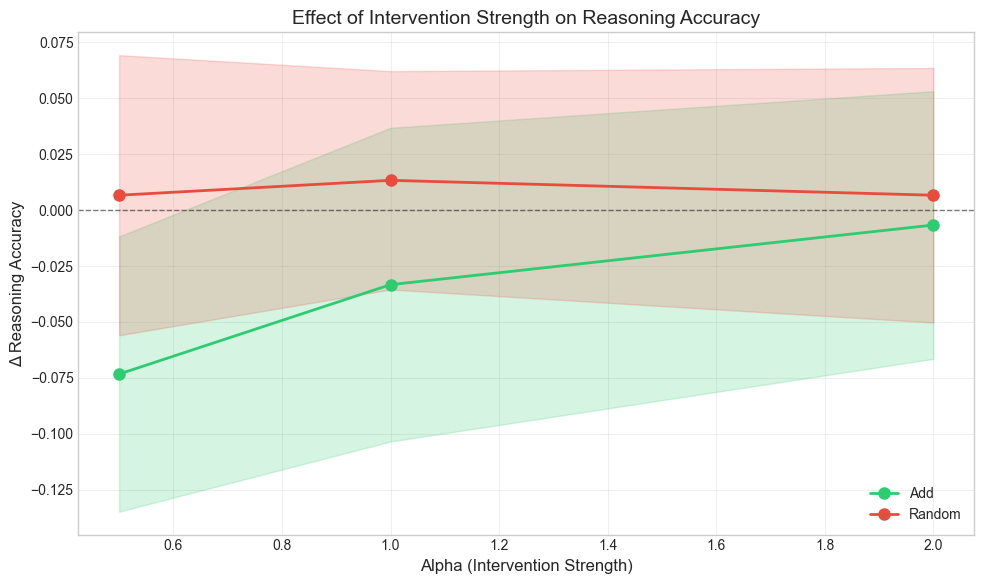

In [8]:
# Alpha sweep for reasoning accuracy
fig, ax = plots.plot_alpha_sweep(paired_df, metric='reasoning',
                                  title='Effect of Intervention Strength on Reasoning Accuracy',
                                  save_path=OUTPUT_DIR / 'alpha_sweep_reasoning.pdf')
plt.show()

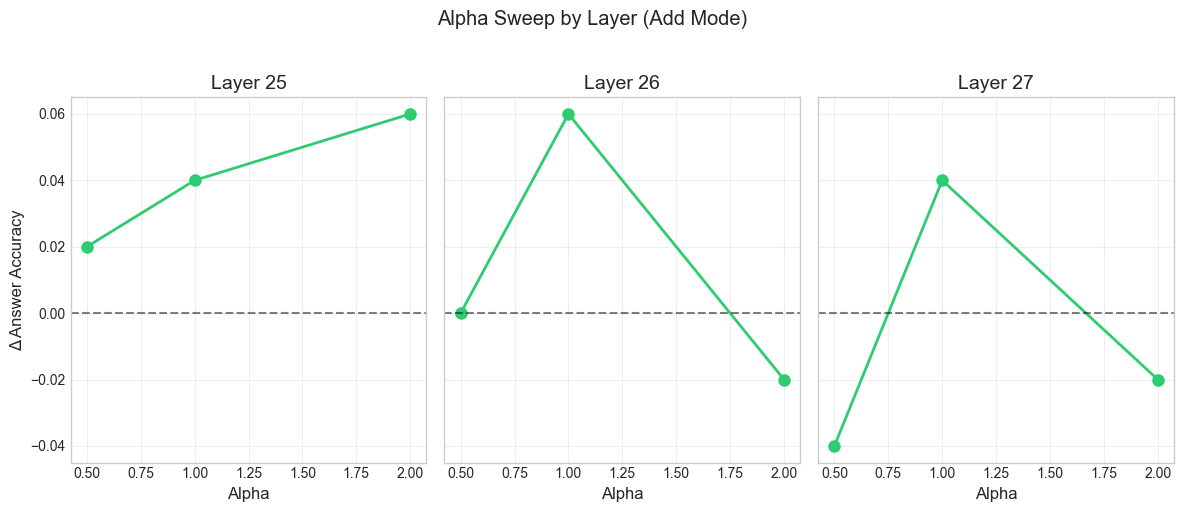

In [9]:
# Alpha sweep by layer (add mode only)
fig, axes = plots.plot_alpha_sweep_by_layer(paired_df, mode='add', metric='answer',
                                             save_path=OUTPUT_DIR / 'alpha_sweep_by_layer.pdf')
plt.show()

In [10]:
# Per-alpha summary for add mode
add_alpha_summary = metrics.compute_per_alpha_summary(paired_df, mode='add')
print("Add Mode: Summary by Alpha")
display(add_alpha_summary)

Add Mode: Summary by Alpha


,alpha,n,acc_base_answer,acc_intv_answer,delta_answer,acc_base_reasoning,acc_intv_reasoning,delta_reasoning,answer_wrong_to_right,answer_right_to_wrong,answer_net_gain,answer_total_flips
0,0.5,150,0.526667,0.520000,-0.006667,0.853333,0.780000,-0.073333,3,4,-1,7
1,1.0,150,0.480000,0.526667,0.046667,0.793333,0.760000,-0.033333,8,1,7,9
2,2.0,150,0.513333,0.520000,0.006667,0.820000,0.813333,-0.006667,4,3,1,7


In [11]:
# Per-alpha summary for random mode
random_alpha_summary = metrics.compute_per_alpha_summary(paired_df, mode='random')
print("Random Mode: Summary by Alpha")
display(random_alpha_summary)

Random Mode: Summary by Alpha


,alpha,n,acc_base_answer,acc_intv_answer,delta_answer,acc_base_reasoning,acc_intv_reasoning,delta_reasoning,answer_wrong_to_right,answer_right_to_wrong,answer_net_gain,answer_total_flips
0,0.5,150,0.500000,0.513333,0.013333,0.806667,0.813333,0.006667,6,4,2,10
1,1.0,150,0.513333,0.506667,-0.006667,0.786667,0.800000,0.013333,2,3,-1,5
2,2.0,150,0.513333,0.526667,0.013333,0.833333,0.840000,0.006667,5,3,2,8


## 4. Flip Analysis

What happens to individual examples under intervention?

In [12]:
# Flip counts per mode
flip_table = metrics.generate_flip_table(paired_df)
print("Flip Analysis by Mode:")
display(flip_table)

Flip Analysis by Mode:


,wrong_to_right,right_to_wrong,net_gain,total_flips,mode,flip_rate
0,15,8,7,23,add,0.051111
1,13,10,3,23,random,0.051111


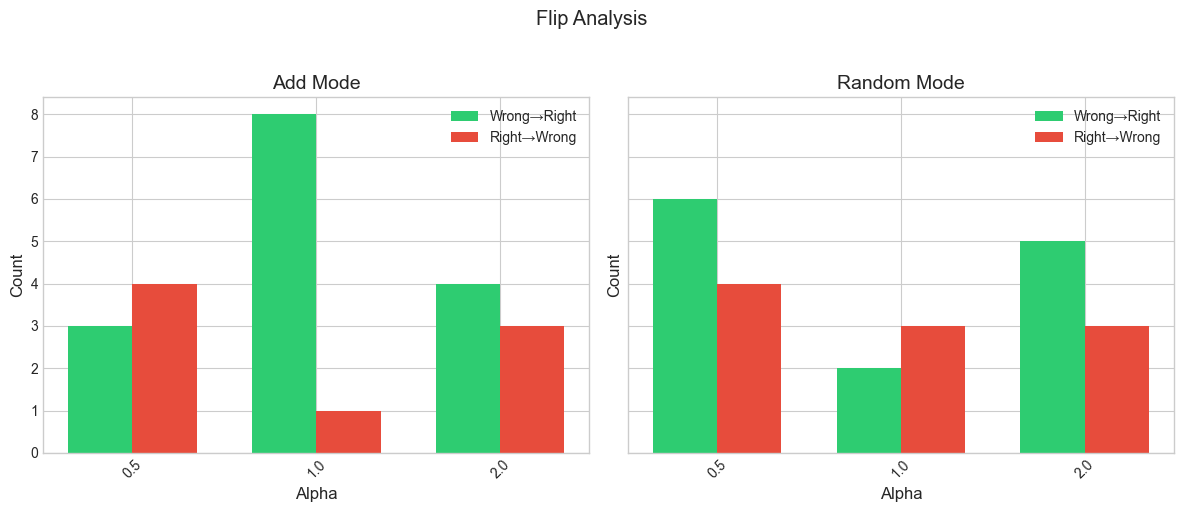

In [13]:
# Flip bar chart
fig, axes = plots.plot_flip_bars(paired_df, group_by='alpha', metric='answer',
                                  save_path=OUTPUT_DIR / 'flip_bars.pdf')
plt.show()

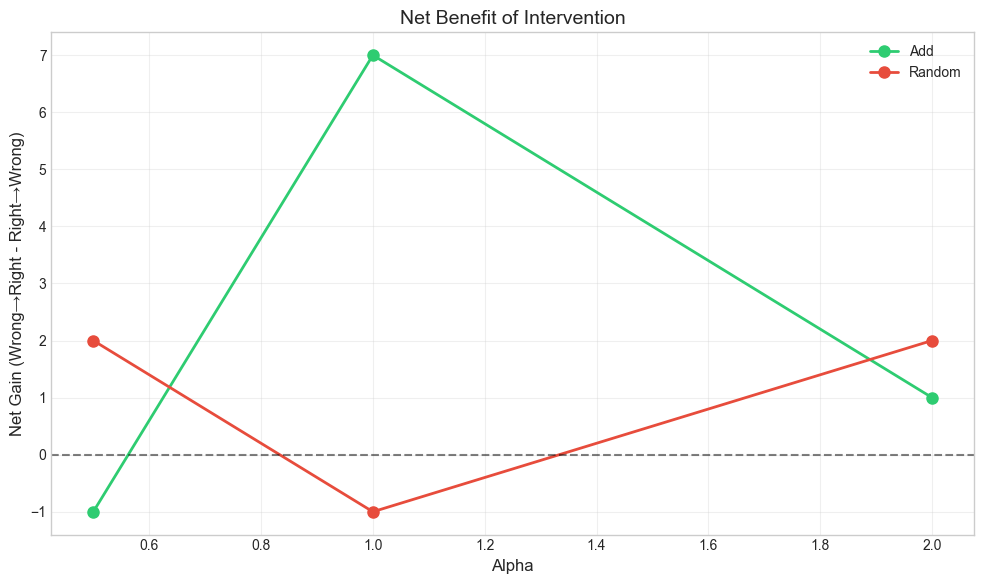

In [14]:
# Net gain plot
fig, ax = plots.plot_net_gain(paired_df, metric='answer',
                               save_path=OUTPUT_DIR / 'net_gain.pdf')
plt.show()

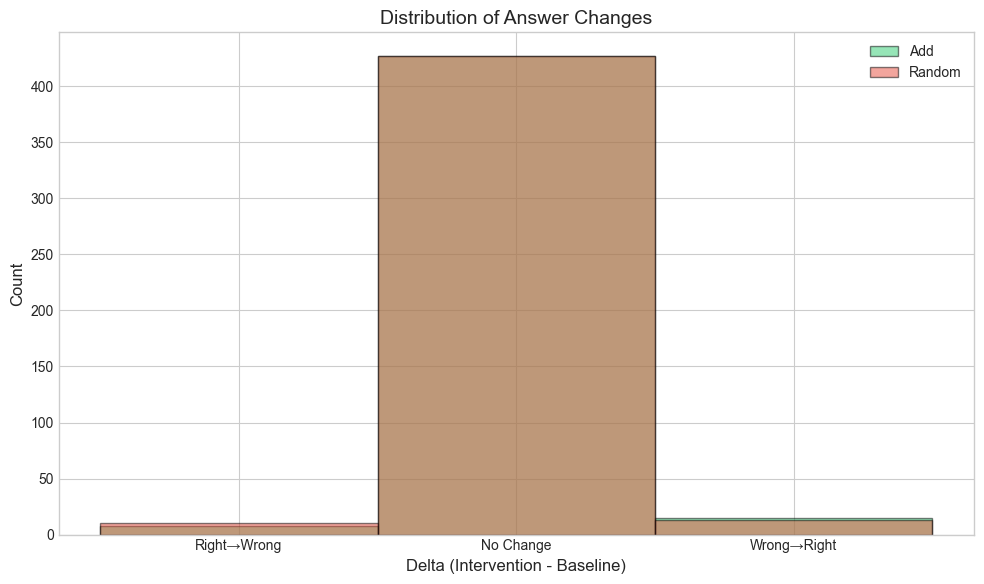

In [15]:
# Delta distribution
fig, ax = plots.plot_delta_distribution(paired_df, metric='answer',
                                         save_path=OUTPUT_DIR / 'delta_distribution.pdf')
plt.show()

## 5. Specificity Analysis: Add vs Random

Is the learned reasoning direction better than random directions?

In [16]:
# Compute specificity
specificity = metrics.compute_specificity(paired_df, 'answer')
print(f"Specificity (Add - Random): {specificity:+.4f}")
print(f"  Interpretation: {'Add mode is better' if specificity > 0 else 'Random mode is better or equal'}")

Specificity (Add - Random): +0.0089
  Interpretation: Add mode is better


In [17]:
# Mode comparison table
comparison = metrics.compare_modes(paired_df, 'add', 'random', 'answer')
print("\nAdd vs Random Comparison by Configuration:")
display(comparison)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

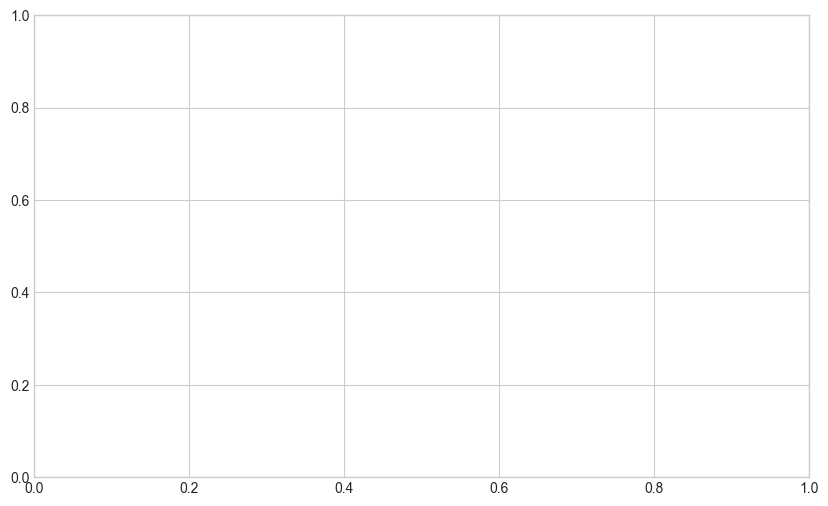

In [ ]:
# Specificity heatmap
fig, ax = plots.plot_specificity_heatmap(paired_df, metric='answer',
                                          save_path=OUTPUT_DIR / 'specificity_heatmap.pdf')
plt.show()

In [ ]:
# Delta heatmap for add mode
fig, ax = plots.plot_delta_heatmap(paired_df, mode='add', metric='answer',
                                    title='Delta Accuracy: Add Mode',
                                    save_path=OUTPUT_DIR / 'heatmap_add.pdf')
plt.show()

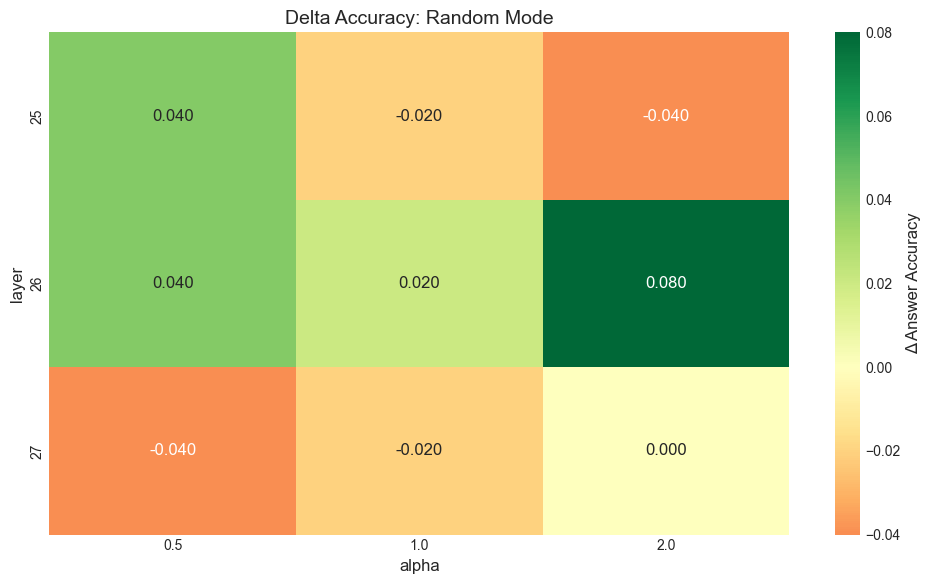

In [18]:
# Delta heatmap for random mode
fig, ax = plots.plot_delta_heatmap(paired_df, mode='random', metric='answer',
                                    title='Delta Accuracy: Random Mode',
                                    save_path=OUTPUT_DIR / 'heatmap_random.pdf')
plt.show()

## 6. Layer Sensitivity Analysis

Which layers are most sensitive to interventions?

In [19]:
# Per-layer summary
layer_summary = metrics.compute_per_layer_summary(paired_df, mode='add')
print("Add Mode: Summary by Layer")
display(layer_summary)

Add Mode: Summary by Layer


,layer,n,acc_base_answer,acc_intv_answer,delta_answer,acc_base_reasoning,acc_intv_reasoning,delta_reasoning,answer_wrong_to_right,answer_right_to_wrong,answer_net_gain,answer_total_flips
0,25,150,0.493333,0.533333,0.040000,0.840000,0.773333,-0.066667,8,2,6,10
1,26,150,0.506667,0.520000,0.013333,0.806667,0.780000,-0.026667,5,3,2,8
2,27,150,0.520000,0.513333,-0.006667,0.820000,0.800000,-0.020000,2,3,-1,5


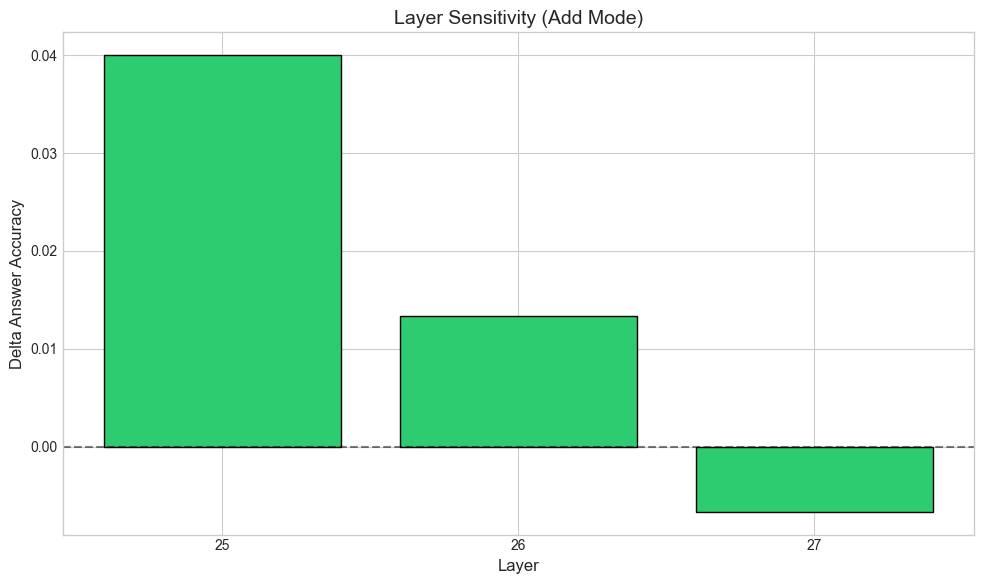

In [20]:
# Layer comparison
if 'layer' in paired_df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    add_df = paired_df[paired_df['mode'] == 'add']
    agg = metrics.aggregate_by_config(add_df, ['layer'], 'answer')
    
    if len(agg) > 0:
        ax.bar(agg['layer'].astype(str), agg['delta'], color='#2ecc71', edgecolor='black')
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('Layer')
        ax.set_ylabel('Delta Answer Accuracy')
        ax.set_title('Layer Sensitivity (Add Mode)')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'layer_sensitivity.pdf', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Lesion Analysis (Necessity)

**Key Question:** Does removing/zeroing out the reasoning direction component harm model performance?

If the reasoning direction is truly necessary for correct reasoning, then lesioning it should:
1. Decrease answer accuracy
2. Decrease reasoning quality
3. Produce more right→wrong flips than wrong→right flips

In [21]:
# Check lesion data availability
print(f"Lesion experiments available: {len(lesion_df)} rows")
if len(lesion_df) > 0:
    print(f"\nLesion data columns: {list(lesion_df.columns)}")
    print(f"\nUnique layers tested: {lesion_df['layer'].unique() if 'layer' in lesion_df.columns else 'N/A'}")

Lesion experiments available: 150 rows

Lesion data columns: ['example_id', 'task_type', 'prompt_mode', 'locality', 'gold', 'allowed_letters', 'baseline_answer_correct', 'baseline_reasoning_correct', 'baseline_correct_regex', 'baseline_pred_regex', 'gen_ms_base', 'n_gen_tokens_base', 'intv_answer_correct', 'intv_reasoning_correct', 'intv_correct_regex', 'intv_pred_regex', 'gen_ms_intv', 'n_gen_tokens_intv', 'intv_answer_detected_at', 'mode', 'layer', 'alpha', 'gamma', 'beta', 'experiment_type', 'source_file', 'lesion_answer_correct', 'lesion_reasoning_correct', 'lesion_correct_regex', 'lesion_pred_regex', 'lesion_text_raw', 'gen_ms_lesion', 'n_gen_tokens_lesion', 'rescue_answer_correct', 'rescue_reasoning_correct', 'rescue_correct_regex', 'rescue_pred_regex', 'rescue_text_raw', 'gen_ms_rescue', 'n_gen_tokens_rescue', 'dataset', 'model', 'experiment_name']

Unique layers tested: [25 26 27]


In [22]:
# Compute detailed lesion effect
if len(lesion_df) > 0:
    print("="*60)
    print("LESION EXPERIMENT RESULTS")
    print("="*60)
    
    lesion_effect = metrics.compute_lesion_effect(lesion_df, 'answer')
    print("\nOverall Lesion Effect (Answer Accuracy):")
    for key, value in lesion_effect.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
    
    print("\n" + "-"*40)
    
    lesion_effect_reasoning = metrics.compute_lesion_effect(lesion_df, 'reasoning')
    print("\nOverall Lesion Effect (Reasoning Accuracy):")
    for key, value in lesion_effect_reasoning.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
else:
    print("No lesion experiments found")

LESION EXPERIMENT RESULTS

Overall Lesion Effect (Answer Accuracy):
  baseline_acc: 0.5133
  lesion_acc: 0.5200
  delta: 0.0067
  n: 150

----------------------------------------

Overall Lesion Effect (Reasoning Accuracy):
  baseline_acc: 0.8200
  lesion_acc: 0.8467
  delta: 0.0267
  n: 150


In [23]:
# Per-layer lesion analysis
if len(lesion_df) > 0 and 'layer' in lesion_df.columns:
    print("\nLesion Effect by Layer:")
    print("="*60)
    
    lesion_by_layer = []
    for layer in sorted(lesion_df['layer'].unique()):
        layer_df = lesion_df[lesion_df['layer'] == layer]
        
        # Compute metrics for this layer
        effect = metrics.compute_lesion_effect(layer_df, 'answer')
        
        lesion_by_layer.append({
            'layer': layer,
            'n': len(layer_df),
            'baseline_acc': effect.get('baseline_accuracy', np.nan),
            'lesion_acc': effect.get('intv_accuracy', np.nan),
            'delta': effect.get('delta', np.nan),
            'wrong_to_right': effect.get('wrong_to_right', 0),
            'right_to_wrong': effect.get('right_to_wrong', 0),
            'net_gain': effect.get('net_gain', 0)
        })
    
    lesion_by_layer_df = pd.DataFrame(lesion_by_layer)
    display(lesion_by_layer_df)


Lesion Effect by Layer:


,layer,n,baseline_acc,lesion_acc,delta,wrong_to_right,right_to_wrong,net_gain
0,25,50,NaN,NaN,-0.04,0,0,0
1,26,50,NaN,NaN,0.04,0,0,0
2,27,50,NaN,NaN,0.02,0,0,0


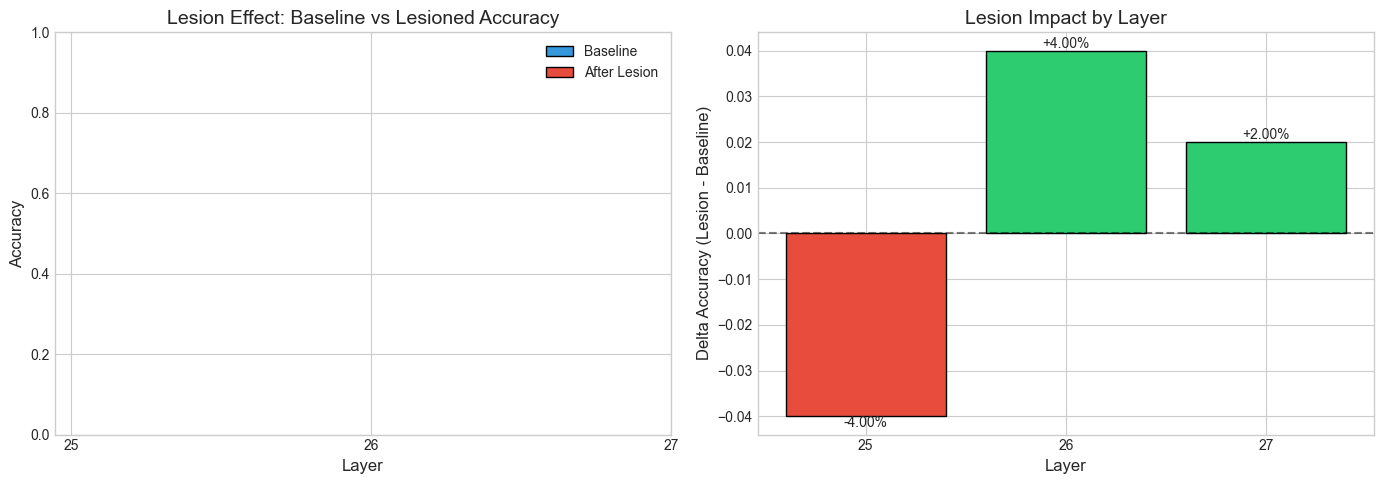

In [24]:
# Visualize lesion effect by layer
if len(lesion_df) > 0 and 'layer' in lesion_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Accuracy comparison (baseline vs lesion)
    ax1 = axes[0]
    layers = lesion_by_layer_df['layer'].astype(str)
    x = np.arange(len(layers))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, lesion_by_layer_df['baseline_acc'], width, 
                    label='Baseline', color='#3498db', edgecolor='black')
    bars2 = ax1.bar(x + width/2, lesion_by_layer_df['lesion_acc'], width,
                    label='After Lesion', color='#e74c3c', edgecolor='black')
    
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Lesion Effect: Baseline vs Lesioned Accuracy')
    ax1.set_xticks(x)
    ax1.set_xticklabels(layers)
    ax1.legend()
    ax1.set_ylim(0, 1)
    
    # Right: Delta (lesion - baseline)
    ax2 = axes[1]
    colors = ['#e74c3c' if d < 0 else '#2ecc71' for d in lesion_by_layer_df['delta']]
    ax2.bar(layers, lesion_by_layer_df['delta'], color=colors, edgecolor='black')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Delta Accuracy (Lesion - Baseline)')
    ax2.set_title('Lesion Impact by Layer')
    
    # Add value labels
    for i, (layer, delta) in enumerate(zip(layers, lesion_by_layer_df['delta'])):
        ax2.annotate(f'{delta:+.2%}', (i, delta), ha='center', 
                    va='bottom' if delta >= 0 else 'top', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'lesion_by_layer.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
# Lesion flip analysis
if len(lesion_df) > 0:
    print("\nLesion Flip Analysis:")
    print("="*60)
    
    # Per-layer flip counts
    flip_data = []
    for layer in sorted(lesion_df['layer'].unique()) if 'layer' in lesion_df.columns else [None]:
        if layer is not None:
            layer_df = lesion_df[lesion_df['layer'] == layer]
        else:
            layer_df = lesion_df
        
        w2r = metrics.count_wrong_to_right(layer_df, 'answer')
        r2w = metrics.count_right_to_wrong(layer_df, 'answer')
        
        flip_data.append({
            'layer': layer if layer is not None else 'all',
            'wrong_to_right': w2r,
            'right_to_wrong': r2w,
            'net_gain': w2r - r2w,
            'interpretation': 'Lesion helps' if w2r > r2w else ('Lesion hurts' if r2w > w2r else 'No effect')
        })
    
    flip_df = pd.DataFrame(flip_data)
    display(flip_df)
    
    print("\nInterpretation:")
    print("- Negative net_gain → Lesion hurts (more examples broken than fixed)")
    print("- Positive net_gain → Lesion helps (surprising, suggests direction is harmful)")
    print("- Zero net_gain → No net effect from lesioning")


Lesion Flip Analysis:


,layer,wrong_to_right,right_to_wrong,net_gain,interpretation
0,25,1,3,-2,Lesion hurts
1,26,2,0,2,Lesion helps
2,27,1,0,1,Lesion helps



Interpretation:
- Negative net_gain → Lesion hurts (more examples broken than fixed)
- Positive net_gain → Lesion helps (surprising, suggests direction is harmful)
- Zero net_gain → No net effect from lesioning


## 8. Rescue Analysis (Recovery)

**Key Question:** After lesioning, can we restore performance by adding back the reasoning direction?

The rescue experiment tests the causal chain:
1. **Baseline** → original performance
2. **Lesion** → remove reasoning direction → (hopefully) decreased performance  
3. **Rescue** → lesion + add back → (hopefully) restored performance

**Recovery Rate** = (Rescue_acc - Lesion_acc) / (Baseline_acc - Lesion_acc)

In [26]:
# Check rescue data availability
print(f"Rescue experiments available: {len(rescue_df)} rows")
print(f"Rescue summary available: {len(rescue_summary)} rows")

if len(rescue_summary) > 0:
    print("\nRescue summary columns:", list(rescue_summary.columns))

Rescue experiments available: 150 rows
Rescue summary available: 6 rows

Rescue summary columns: ['mode', 'locality', 'layer', 'gamma', 'beta', 'n', 'acc_base_answer', 'acc_lesion_answer', 'acc_rescue_answer', 'delta_lesion_answer', 'recovery_answer', 'acc_base_reasoning', 'acc_lesion_reasoning', 'acc_rescue_reasoning', 'full_recovery', 'model', 'dataset', 'experiment_name']


In [27]:
# Display the full rescue summary
if len(rescue_summary) > 0:
    print("="*60)
    print("RESCUE EXPERIMENT SUMMARY")
    print("="*60)
    print("\nThis table shows the full causal chain: Baseline → Lesion → Rescue")
    display(rescue_summary)

RESCUE EXPERIMENT SUMMARY

This table shows the full causal chain: Baseline → Lesion → Rescue


,mode,locality,layer,gamma,beta,n,acc_base_answer,acc_lesion_answer,acc_rescue_answer,delta_lesion_answer,recovery_answer,acc_base_reasoning,acc_lesion_reasoning,acc_rescue_reasoning,full_recovery,model,dataset,experiment_name
0,rescue,answer,27,1.0,1.0,25,0.48,0.56,0.52,0.08,-0.04,0.80,0.80,0.72,0,Qwen2.5-7B-Instruct,mmlu_pro,Qwen2.5-7B-Instruct__answer_locality_20251202_...
1,rescue,answer,26,1.0,1.0,25,0.52,0.52,0.48,0.00,-0.04,0.84,0.84,0.80,0,Qwen2.5-7B-Instruct,mmlu_pro,Qwen2.5-7B-Instruct__answer_locality_20251202_...
2,rescue,answer,25,1.0,1.0,25,0.48,0.52,0.48,0.04,-0.04,0.84,0.76,0.84,0,Qwen2.5-7B-Instruct,mmlu_pro,Qwen2.5-7B-Instruct__answer_locality_20251202_...
3,rescue,cot,27,1.0,1.0,25,0.52,0.52,0.52,0.00,0.00,0.80,0.80,0.84,0,Qwen2.5-7B-Instruct,mmlu_pro,Qwen2.5-7B-Instruct__cot_locality_20251201_235957
4,rescue,cot,26,1.0,1.0,25,0.52,0.52,0.56,0.00,0.04,0.84,0.80,0.72,1,Qwen2.5-7B-Instruct,mmlu_pro,Qwen2.5-7B-Instruct__cot_locality_20251201_235957
5,rescue,cot,25,1.0,1.0,25,0.56,0.52,0.48,-0.04,-0.04,0.88,0.84,0.84,0,Qwen2.5-7B-Instruct,mmlu_pro,Qwen2.5-7B-Instruct__cot_locality_20251201_235957


In [28]:
# Analyze rescue results in detail
if len(rescue_summary) > 0:
    print("\nDetailed Rescue Analysis:")
    print("="*60)
    
    for idx, row in rescue_summary.iterrows():
        layer = row.get('layer', 'unknown')
        gamma = row.get('gamma', 'N/A')
        beta = row.get('beta', 'N/A')
        
        print(f"\nLayer {layer} (γ={gamma}, β={beta}):")
        print("-" * 40)
        
        # Answer accuracy chain
        base_ans = row.get('acc_base_answer', np.nan)
        lesion_ans = row.get('acc_lesion_answer', np.nan)
        rescue_ans = row.get('acc_rescue_answer', np.nan)
        
        print(f"  Answer Accuracy:")
        print(f"    Baseline:  {base_ans:.1%}")
        print(f"    Lesion:    {lesion_ans:.1%} (Δ = {lesion_ans - base_ans:+.1%})")
        print(f"    Rescue:    {rescue_ans:.1%} (Δ from lesion = {rescue_ans - lesion_ans:+.1%})")
        
        # Recovery rate
        if base_ans != lesion_ans:
            recovery = (rescue_ans - lesion_ans) / (base_ans - lesion_ans)
            print(f"    Recovery rate: {recovery:.1%}")
        else:
            print(f"    Recovery rate: N/A (no lesion effect)")
        
        # Reasoning accuracy chain
        base_reas = row.get('acc_base_reasoning', np.nan)
        lesion_reas = row.get('acc_lesion_reasoning', np.nan)
        rescue_reas = row.get('acc_rescue_reasoning', np.nan)
        
        print(f"\n  Reasoning Accuracy:")
        print(f"    Baseline:  {base_reas:.1%}")
        print(f"    Lesion:    {lesion_reas:.1%} (Δ = {lesion_reas - base_reas:+.1%})")
        print(f"    Rescue:    {rescue_reas:.1%} (Δ from lesion = {rescue_reas - lesion_reas:+.1%})")
        
        # Full recovery count
        full_recovery = row.get('full_recovery', 0)
        n = row.get('n', 0)
        print(f"\n  Full recovery examples: {full_recovery}/{n} ({full_recovery/n:.1%})")


Detailed Rescue Analysis:

Layer 27 (γ=1.0, β=1.0):
----------------------------------------
  Answer Accuracy:
    Baseline:  48.0%
    Lesion:    56.0% (Δ = +8.0%)
    Rescue:    52.0% (Δ from lesion = -4.0%)
    Recovery rate: 50.0%

  Reasoning Accuracy:
    Baseline:  80.0%
    Lesion:    80.0% (Δ = +0.0%)
    Rescue:    72.0% (Δ from lesion = -8.0%)

  Full recovery examples: 0/25 (0.0%)

Layer 26 (γ=1.0, β=1.0):
----------------------------------------
  Answer Accuracy:
    Baseline:  52.0%
    Lesion:    52.0% (Δ = +0.0%)
    Rescue:    48.0% (Δ from lesion = -4.0%)
    Recovery rate: N/A (no lesion effect)

  Reasoning Accuracy:
    Baseline:  84.0%
    Lesion:    84.0% (Δ = +0.0%)
    Rescue:    80.0% (Δ from lesion = -4.0%)

  Full recovery examples: 0/25 (0.0%)

Layer 25 (γ=1.0, β=1.0):
----------------------------------------
  Answer Accuracy:
    Baseline:  48.0%
    Lesion:    52.0% (Δ = +4.0%)
    Rescue:    48.0% (Δ from lesion = -4.0%)
    Recovery rate: 100.0%

  

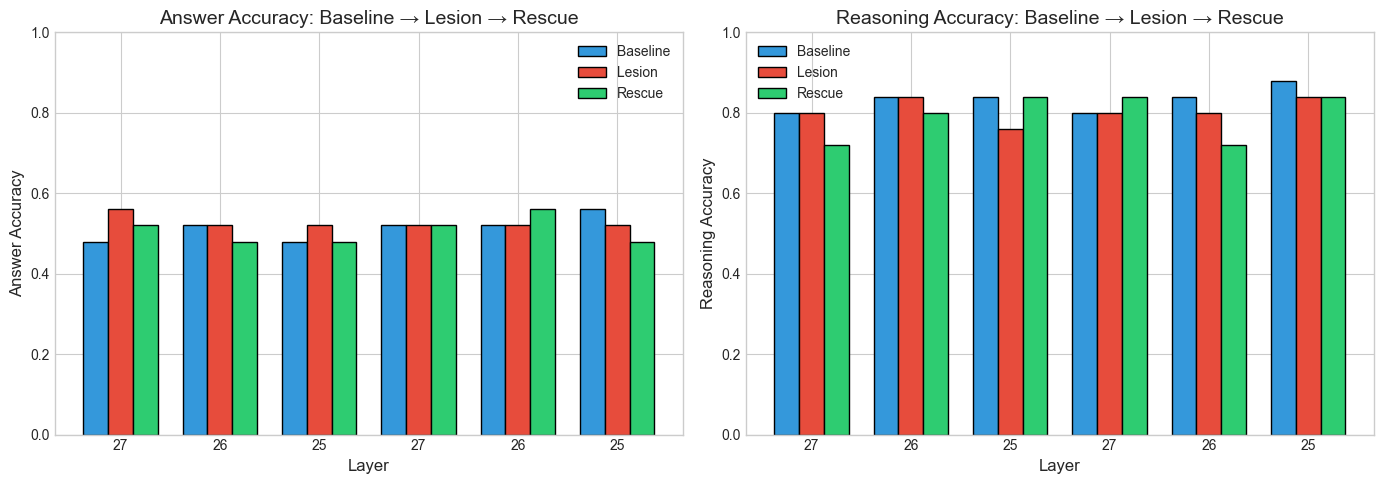

In [29]:
# Visualize the rescue causal chain
if len(rescue_summary) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Prepare data
    layers = rescue_summary['layer'].astype(str).values
    x = np.arange(len(layers))
    width = 0.25
    
    # Left: Answer Accuracy Chain
    ax1 = axes[0]
    bars1 = ax1.bar(x - width, rescue_summary['acc_base_answer'], width,
                    label='Baseline', color='#3498db', edgecolor='black')
    bars2 = ax1.bar(x, rescue_summary['acc_lesion_answer'], width,
                    label='Lesion', color='#e74c3c', edgecolor='black')
    bars3 = ax1.bar(x + width, rescue_summary['acc_rescue_answer'], width,
                    label='Rescue', color='#2ecc71', edgecolor='black')
    
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Answer Accuracy')
    ax1.set_title('Answer Accuracy: Baseline → Lesion → Rescue')
    ax1.set_xticks(x)
    ax1.set_xticklabels(layers)
    ax1.legend()
    ax1.set_ylim(0, 1)
    
    # Right: Reasoning Accuracy Chain
    ax2 = axes[1]
    bars4 = ax2.bar(x - width, rescue_summary['acc_base_reasoning'], width,
                    label='Baseline', color='#3498db', edgecolor='black')
    bars5 = ax2.bar(x, rescue_summary['acc_lesion_reasoning'], width,
                    label='Lesion', color='#e74c3c', edgecolor='black')
    bars6 = ax2.bar(x + width, rescue_summary['acc_rescue_reasoning'], width,
                    label='Rescue', color='#2ecc71', edgecolor='black')
    
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Reasoning Accuracy')
    ax2.set_title('Reasoning Accuracy: Baseline → Lesion → Rescue')
    ax2.set_xticks(x)
    ax2.set_xticklabels(layers)
    ax2.legend()
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'rescue_causal_chain.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
# Compute rescue recovery from raw data if available
if len(rescue_df) > 0:
    print("\nRescue Recovery Analysis (from raw data):")
    print("="*60)
    
    rescue_effect = metrics.compute_rescue_recovery(rescue_df, 'answer')
    for key, value in rescue_effect.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")


Rescue Recovery Analysis (from raw data):
  baseline_acc: 0.5133
  rescue_acc: 1.0000
  delta: 0.4867
  n: 150


In [31]:
# Summary interpretation of lesion/rescue
print("\n" + "="*60)
print("LESION/RESCUE INTERPRETATION")
print("="*60)

if len(rescue_summary) > 0:
    # Average effects
    avg_lesion_delta = (rescue_summary['acc_lesion_answer'] - rescue_summary['acc_base_answer']).mean()
    avg_rescue_recovery = (rescue_summary['acc_rescue_answer'] - rescue_summary['acc_lesion_answer']).mean()
    avg_full_chain = (rescue_summary['acc_rescue_answer'] - rescue_summary['acc_base_answer']).mean()
    
    print(f"\nAverage Effects Across Layers:")
    print(f"  Lesion Effect (lesion - baseline): {avg_lesion_delta:+.2%}")
    print(f"  Rescue Effect (rescue - lesion):   {avg_rescue_recovery:+.2%}")
    print(f"  Net Effect (rescue - baseline):    {avg_full_chain:+.2%}")
    
    print(f"\nInterpretation:")
    if avg_lesion_delta < -0.01:
        print(f"  ✓ Lesion hurts: Removing reasoning direction decreases accuracy ({avg_lesion_delta:+.2%})")
        print(f"    → Supports NECESSITY: The reasoning direction is needed for correct answers")
    elif avg_lesion_delta > 0.01:
        print(f"  ⚠ Lesion helps: Removing reasoning direction increases accuracy ({avg_lesion_delta:+.2%})")
        print(f"    → Suggests the direction may be interfering with reasoning")
    else:
        print(f"  ○ Lesion has minimal effect ({avg_lesion_delta:+.2%})")
        print(f"    → The reasoning direction may not be critical at these layers")
    
    print()
    if avg_rescue_recovery > 0.01:
        print(f"  ✓ Rescue works: Adding direction back improves accuracy ({avg_rescue_recovery:+.2%})")
        print(f"    → Supports causal role: Adding direction compensates for lesion damage")
    elif avg_rescue_recovery < -0.01:
        print(f"  ⚠ Rescue backfires: Adding direction back hurts more ({avg_rescue_recovery:+.2%})")
        print(f"    → May indicate over-compensation or wrong layer")
    else:
        print(f"  ○ Rescue has minimal effect ({avg_rescue_recovery:+.2%})")
        print(f"    → Adding back the direction doesn't help recover")
else:
    print("No rescue summary data available for interpretation")


LESION/RESCUE INTERPRETATION

Average Effects Across Layers:
  Lesion Effect (lesion - baseline): +1.33%
  Rescue Effect (rescue - lesion):   -2.00%
  Net Effect (rescue - baseline):    -0.67%

Interpretation:
  ⚠ Lesion helps: Removing reasoning direction increases accuracy (+1.33%)
    → Suggests the direction may be interfering with reasoning

  ⚠ Rescue backfires: Adding direction back hurts more (-2.00%)
    → May indicate over-compensation or wrong layer


## 9. Statistical Tests

In [32]:
# Run all statistical tests
test_results = statistical_tests.run_all_tests(paired_df, 'answer')

In [33]:
# McNemar's test results
print("McNemar's Test Results:")
print("Tests whether the intervention changes outcomes significantly")
print("="*60)
display(test_results['mcnemar'])

McNemar's Test Results:
Tests whether the intervention changes outcomes significantly


,n_discordant,wrong_to_right,right_to_wrong,net_gain,p_value,significant_0.05,significant_0.01,interpretation,mode,alpha_filter,n_total,condition,significant
0,23,15,8,7.0,0.210040,False,False,No significant difference,add,positive,450,add_positive,NaN
1,0,0,0,NaN,1.000000,NaN,NaN,No discordant pairs,add,negative,0,add_negative,False
2,23,15,8,7.0,0.210040,False,False,No significant difference,add,None,450,add_all,NaN
3,23,13,10,3.0,0.677639,False,False,No significant difference,random,positive,450,random_positive,NaN
4,0,0,0,NaN,1.000000,NaN,NaN,No discordant pairs,random,negative,0,random_negative,False
5,23,13,10,3.0,0.677639,False,False,No significant difference,random,None,450,random_all,NaN


In [34]:
# Sign test results
print("\nSign Test Results:")
print("Tests whether positive and negative changes are equally likely")
print("="*60)
display(test_results['sign_test'])


Sign Test Results:
Tests whether positive and negative changes are equally likely


,n_positive,n_negative,n_total,n_zero,p_value,significant,mode,alpha_filter,condition
0,15,8,23,427,0.210040,False,add,positive,add_positive
1,0,0,0,0,1.000000,False,add,negative,add_negative
2,15,8,23,427,0.210040,False,add,None,add_all
3,13,10,23,427,0.677639,False,random,positive,random_positive
4,0,0,0,0,1.000000,False,random,negative,random_negative
5,13,10,23,427,0.677639,False,random,None,random_all


In [35]:
# T-test results
print("\nOne-Sample T-Test Results:")
print("Tests whether mean delta is significantly different from zero")
print("="*60)
display(test_results['ttest'])


One-Sample T-Test Results:
Tests whether mean delta is significantly different from zero


,mean,std,n,t_stat,p_value,significant,mode,alpha_filter,alternative,condition
0,0.015556,0.225793,450,1.461442,0.144594,False,add,positive,two-sided,add_positive
1,NaN,NaN,0,NaN,1.000000,False,NaN,NaN,NaN,add_negative
2,0.015556,0.225793,450,1.461442,0.144594,False,add,None,two-sided,add_all
3,0.006667,0.226231,450,0.625120,0.532210,False,random,positive,two-sided,random_positive
4,NaN,NaN,0,NaN,1.000000,False,NaN,NaN,NaN,random_negative
5,0.006667,0.226231,450,0.625120,0.532210,False,random,None,two-sided,random_all


In [36]:
# Mann-Whitney test results
print("\nMann-Whitney U Test Results:")
print("Tests whether add and random modes have different effects")
print("="*60)
display(test_results['mann_whitney'])


Mann-Whitney U Test Results:
Tests whether add and random modes have different effects


,group1,group2,group1_mean,group2_mean,group1_median,group2_median,group1_n,group2_n,U_stat,p_value,effect_size_r,significant,alpha_value
0,add,random,-0.006667,0.013333,0.0,0.0,150,150,11031.0,0.467852,0.019467,False,0.5
1,add,random,0.046667,-0.006667,0.0,0.0,150,150,11839.0,0.032054,-0.052356,True,1.0
2,add,random,0.006667,0.013333,0.0,0.0,150,150,11176.5,0.796923,0.006533,False,2.0


In [37]:
# Effect sizes
print("\nEffect Sizes (Cohen's d):")
print("Interpretation: |d| < 0.2 negligible, 0.2-0.5 small, 0.5-0.8 medium, >0.8 large")
print("="*60)
display(test_results['effect_sizes'])


Effect Sizes (Cohen's d):
Interpretation: |d| < 0.2 negligible, 0.2-0.5 small, 0.5-0.8 medium, >0.8 large


,mode1,mode2,mode1_mean,mode2_mean,cohens_d,interpretation,group
0,add,random,0.015556,0.006667,0.039329,negligible,overall
1,add,random,0.015556,0.006667,0.039329,negligible,dataset_mmlu_pro
2,add,random,-0.006667,0.013333,-0.083818,negligible,alpha_0.5
3,add,random,0.046667,-0.006667,0.249044,small,alpha_1.0
4,add,random,0.006667,0.013333,-0.029748,negligible,alpha_2.0


In [38]:
# Dose-response regression
print("\nDose-Response Regression:")
print("Tests for linear relationship between alpha and delta accuracy")
print("="*60)
display(test_results['dose_response'])


Dose-Response Regression:
Tests for linear relationship between alpha and delta accuracy


,mode,slope,slope_se,intercept,r_squared,p_value,significant,n
0,add,0.001905,0.017087,0.013333,0.000028,0.911291,False,450
1,random,0.002857,0.017120,0.003333,0.000062,0.867532,False,450


In [39]:
# Bootstrap confidence intervals
print("\nBootstrap 95% Confidence Intervals:")
print("="*60)

for mode in ['add', 'random']:
    ci = statistical_tests.compute_bootstrap_ci(paired_df, mode=mode, metric='answer')
    if 'error' not in ci:
        print(f"\n{mode.capitalize()} mode:")
        print(f"  Mean delta: {ci['mean']:.4f}")
        print(f"  95% CI: [{ci['ci_lower']:.4f}, {ci['ci_upper']:.4f}]")


Bootstrap 95% Confidence Intervals:

Add mode:
  Mean delta: 0.0156
  95% CI: [-0.0044, 0.0356]

Random mode:
  Mean delta: 0.0067
  95% CI: [-0.0133, 0.0267]


## 10. Summary Dashboard

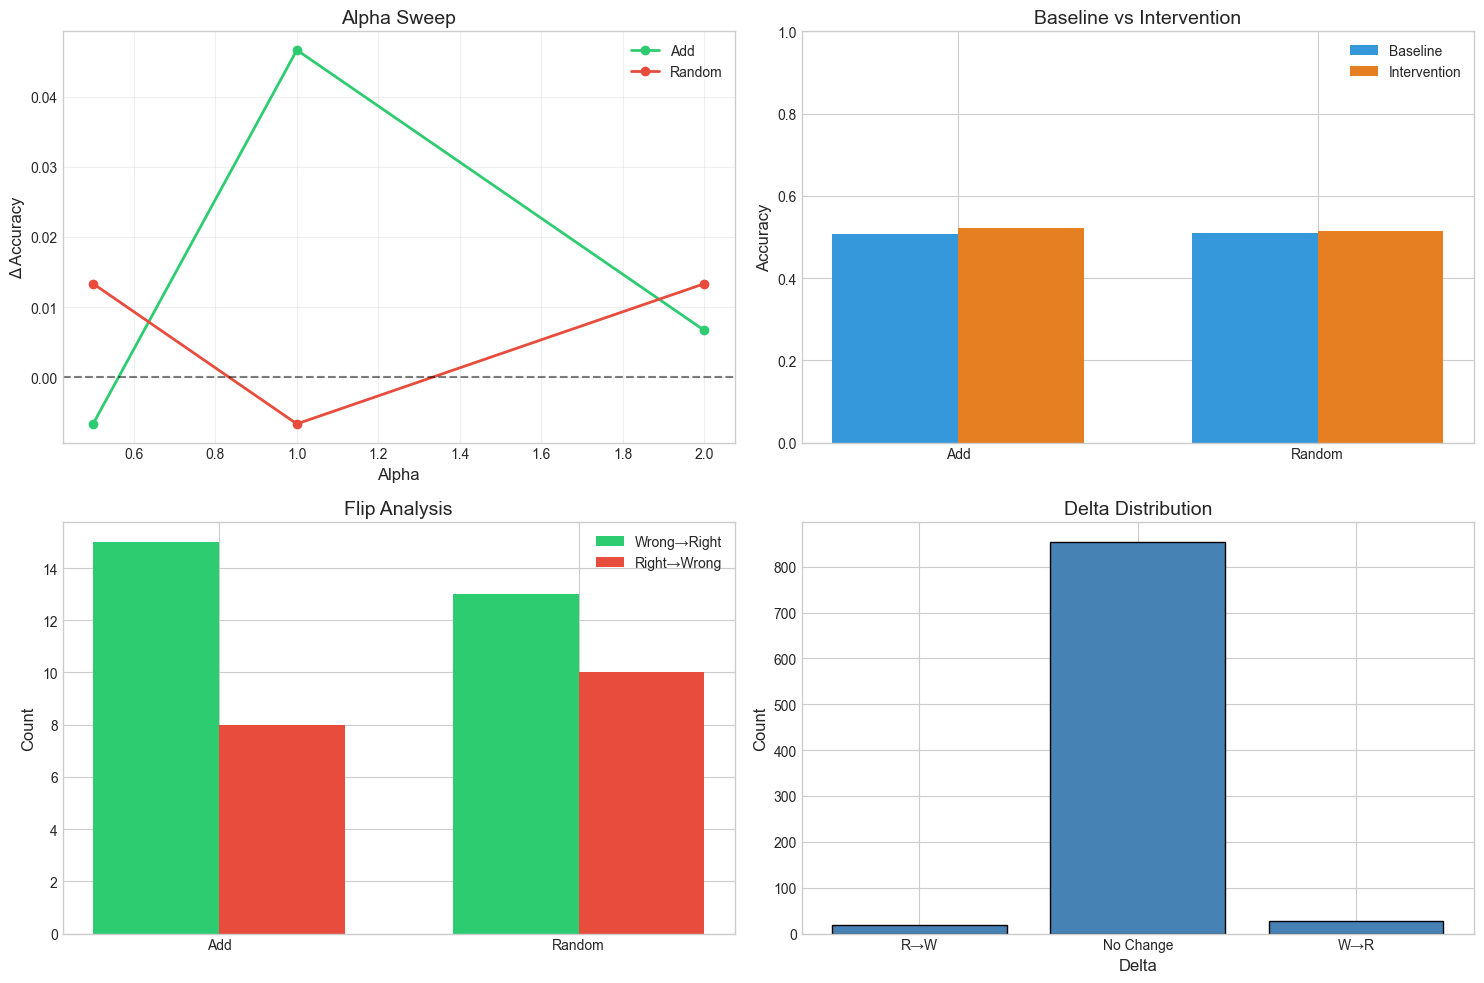

In [40]:
# Generate summary dashboard
fig, axes = plots.plot_summary_dashboard(paired_df, metric='answer',
                                          save_path=OUTPUT_DIR / 'summary_dashboard.pdf')
plt.show()

## 11. Conclusions

### Key Findings

Based on the analysis above, summarize:

1. **Sufficiency** (α > 0):
   - Does adding the reasoning direction improve performance?
   - [Fill in based on results]

2. **Necessity** (Lesion):
   - Does removing the reasoning direction harm performance?
   - [Fill in based on lesion analysis in Section 7]

3. **Specificity** (Add vs Random):
   - Is the learned direction better than random directions?
   - [Fill in based on results]

4. **Rescue**:
   - Does lesion→add restore original behavior?
   - [Fill in based on rescue analysis in Section 8]

5. **Layer Sensitivity**:
   - Which layers are most affected by interventions?
   - [Fill in based on results]

In [41]:
# Save all results to CSV
agg_df.to_csv(OUTPUT_DIR / 'aggregated_results.csv', index=False)

for test_name, test_df in test_results.items():
    if len(test_df) > 0:
        test_df.to_csv(OUTPUT_DIR / f'test_{test_name}.csv', index=False)

# Save lesion analysis if available
if 'lesion_by_layer_df' in dir():
    lesion_by_layer_df.to_csv(OUTPUT_DIR / 'lesion_by_layer.csv', index=False)

# Save rescue summary
if len(rescue_summary) > 0:
    rescue_summary.to_csv(OUTPUT_DIR / 'rescue_analysis.csv', index=False)

print(f"Results saved to {OUTPUT_DIR}")
print("\nFiles generated:")
for f in sorted(OUTPUT_DIR.glob('*')):
    print(f"  - {f.name}")

Results saved to ../outputs

Files generated:
  - aggregated_results.csv
  - alpha_sweep_answer.pdf
  - alpha_sweep_by_layer.pdf
  - alpha_sweep_reasoning.pdf
  - baseline_distribution.png
  - coverage_heatmap.png
  - coverage_layer_alpha.png
  - delta_distribution.pdf
  - flip_bars.pdf
  - heatmap_add.pdf
  - heatmap_random.pdf
  - layer_sensitivity.pdf
  - lesion_by_layer.csv
  - lesion_by_layer.pdf
  - locality_comparison
  - net_gain.pdf
  - rescue_analysis.csv
  - rescue_causal_chain.pdf
  - summary_dashboard.pdf
  - test_dose_response.csv
  - test_effect_sizes.csv
  - test_mann_whitney.csv
  - test_mcnemar.csv
  - test_sign_test.csv
  - test_ttest.csv
